In [1]:
import pandas as pd
import numpy as np
import json
import datetime
import re
import matplotlib.pyplot as plt

# Anomaly detection

This is "use case c" from the list of planned use cases:
1. (a). **Trends monitoring**. User specifies log fields to monitor and specifies their min/max/alert levels. Tool makes prognosis and form summary for these log fields (and also for system load, e.g. number of messages per hour). The prognosis is based on previous dynamics, previous/future working days, holidays, and other events (like maintenance windows).
1. (b). **Logs comparison**. User compares current logs with the previous ones (e.g. from previous release). User selects log fields to analyze. Tool highlights high-level differences, like number of messages, differences in prev/next hops, maybe different trends of field values.
1. (c). **Anomalies in logs**. Tool tries to find messages, which don’t look similar to most of others (for example, less than 1%). One more case: cluster log messages, if we see several types of them.
1. (d). **Automatic fault detection**. Tool automatically finds and highlight failures, basing on HTTP codes and, probably, other fields.
1. (e). **Failure patterns**. Using the data from automatic failure detection module, tool tries to find any pattern in failures, like occurring only on 5th time after connection setup, also it tries to find precursors to failure (certain messages or values, which appear before it happens)

**Notes**:
1. If data distribution is "highly multimodal" (at least "highly bimodal"), for example, like Arcsine distribution, then Tukey fences don't work: they show either both type of anomalies for all data or no anomalies at all. This can happen if messages come to server in sharp-ended continuous queues (see the last case, but with increased length of "rare messages" window). Maybe, in this case increasing of sliding window should help. These cases are not covered below.

**TODO**:
1. Maybe, write a solution for bimodal distributions

## Service Functions

In [2]:
def load_logs(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        logs = json.load(f)
    return logs


def get_log_events(logs_dict, ts_win_address, win_size_sec):
    ts_vals = logs_dict
    for hop in ts_win_address.split('.'):
        new_ts_vals = []
        for msg in ts_vals:
            if hop not in msg:
                print(f"WARNING: didn't find \"{hop}\" in message {msg}")
            else:
                new_ts_vals.append(msg[hop])
        ts_vals = new_ts_vals

    if re.match(r'\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}\.\d+Z', ts_vals[0]):
        # full timestamp with milliseconds
        format_str = '%Y-%m-%dT%H:%M:%S.%fZ'
    elif re.match(r'\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}Z', ts_vals[0]):
        # timestamp with missed milliseconds
        format_str = '%Y-%m-%dT%H:%M:%SZ'
    else:
        raise Exception(f"ERROR: unknown time format: {ts_vals[0]}")
    ts_vals = sorted([
        datetime.datetime.strptime(ts, format_str)
        for ts in ts_vals
    ])  # automatic ISO conversion with "fromisoformat()" is supported only from Python 3.11
    
    idx_freq = max(win_size_sec//2, 1)
    event_idx = pd.date_range(
        start=ts_vals[0],
        end=ts_vals[-1] + datetime.timedelta(seconds=1),
        freq=f'{idx_freq}s',
    )
    event_cnt = []
    idx = 0
    prev_time = None
    for next_time in event_idx:
        if prev_time is None:
            prev_time = next_time
            continue
        cnt = 0
        while idx < len(ts_vals) and ts_vals[idx] >= prev_time and ts_vals[idx] < next_time:
            cnt += 1
            idx += 1
        event_cnt.append(cnt)
        prev_time = next_time

    return pd.Series(data=event_cnt, index=event_idx[:-1])


def find_event_time_anomaly(logs_dict, ts_win_address, win_size_sec):

    def windows_to_start_end(detected_win_starts, win_size):
        # remove overlapped and consequtive detected windows from the list and output only (start, end)
        # intervals for the detected anomalies
        if len(detected_win_starts) == 0:
            return []
        detected_wins = detected_win_starts.to_series(index=pd.RangeIndex(len(detected_win_starts)))
        bool_mask = [True] + (detected_wins.diff(1).dropna() > pd.Timedelta(win_size, 's')).values.tolist()
        win_starts = detected_wins[bool_mask].index.tolist()
        win_size_td = datetime.timedelta(seconds=win_size)
        out_windows = []
        for w_idx in range(len(win_starts) - 1):
            out_windows.append(
                (detected_wins[win_starts[w_idx]],
                 detected_wins[win_starts[w_idx + 1] - 1] + win_size_td)
            )
        out_windows.append(
            (detected_wins[win_starts[-1]],
             detected_wins.iat[-1] + win_size_td)
        )  # last window in series
        return out_windows

    ts_s = get_log_events(logs_dict, ts_win_address, win_size_sec)
    freqs = ts_s.rolling(window=f'{win_size_sec}s', min_periods=0).sum()
    freqs.index -= pd.Timedelta(win_size_sec, 's')  # to make window position on left side, not right one

    if len(freqs[freqs == 0]) >= 0.5*len(freqs):
        # heuristic: when logs contain too many "silence periods", we don't analyze them at all,
        # otherwise they will make detector to mark almost any activity period as anomaly,
        # which is usually not true for the server with sporadic load
        freqs = freqs[freqs != 0]

    # Tukey's Fence
    k = 3  # to be sure that value is enough "far out"
    q1 = freqs.quantile(0.25)
    q3 = freqs.quantile(0.75)
    low_thr = q1 - k * (q3 - q1)
    high_thr = q3 + k * (q3 - q1)

    too_rare_events = windows_to_start_end(freqs[freqs < low_thr].index, win_size_sec)
    too_frequent_events = windows_to_start_end(freqs[freqs > high_thr].index, win_size_sec)

    return too_rare_events, too_frequent_events


def plot_anomalies(logs_dict, ts_win_address, win_size_sec, too_rare_list, too_freq_list):
    ts_s = get_log_events(logs_dict, ts_win_address, win_size_sec)

    fig, axs = plt.subplots(2, 1)

    ts_s.plot(ax=axs[0])
    axs[0].set_xlim((None, ts_s.index.tolist()[-1] + datetime.timedelta(seconds=win_size_sec)))
    for (win_start, win_end) in too_rare_list:
        axs[0].axvspan(win_start, win_end, color='blue', alpha=0.3)
    for (win_start, win_end) in too_freq_list:
        axs[0].axvspan(win_start, win_end, color='red', alpha=0.3)
    axs[0].set_xlabel(f"Time: \"{ts_win_address}\"")
    axs[0].set_ylabel("Messages per second")
    axs[0].set_title(f"Too rare (blue) and too frequesnt (red) messages")

    freqs = ts_s.rolling(window=f'{win_size_sec}s', min_periods=0).sum()
    freqs.index -= pd.Timedelta(win_size_sec, 's')  # to make window position on left side, not right one
    freqs.plot(ax=axs[1])
    axs[1].set_xlim((None, ts_s.index.tolist()[-1] + datetime.timedelta(seconds=win_size_sec)))
    for (win_start, win_end) in too_rare_list:
        axs[1].axvspan(win_start, win_end, color='blue', alpha=0.3)
    for (win_start, win_end) in too_freq_list:
        axs[1].axvspan(win_start, win_end, color='red', alpha=0.3)
    axs[1].set_xlabel(f"Time: \"{ts_win_address}\"")
    axs[1].set_ylabel("Messages in window")
    axs[1].set_title(f"Too rare and too frequesnt messages in sliding window of {win_size_sec} sec")

    plt.tight_layout()
    plt.show()


def report_anomalies(logs_dict, ts_win_address, win_size_sec):
    too_rare_list, too_freq_list = find_event_time_anomaly(logs_dict, ts_win_address, win_size_sec)
    plot_anomalies(logs_dict, ts_win_address, win_size_sec, too_rare_list, too_freq_list)

    if len(too_rare_list) > 0:
        print("Anomaly found: too rare messages in the following time frames:")
        for (win_start, win_end) in too_rare_list:
            print(f"\t from {win_start} to {win_end}")
    if len(too_freq_list) > 0:
        print("Anomaly found: too frequent messages in the following time frames:")
        for (win_start, win_end) in too_freq_list:
            print(f"\t from {win_start} to {win_end}")
    
    if len(too_rare_list) == 0 and len(too_freq_list) == 0:
        print("No anomalies found")

## Experiments

### Logs from ElasticSearch

In [3]:
logs_dict = load_logs('data/elastic_logs_example_01.json')

In [4]:
for key in logs_dict[0].keys():
    print(key)
    if isinstance(logs_dict[0][key], dict):
        for ckey in logs_dict[0][key].keys():
            print(f"\t{ckey}")

cloud
	provider
	service
	region
	account
observer
	hostname
	type
	version
agent
	activation_method
	name
	version
faas
	execution
	id
process
	args
	parent
	pid
	title
@timestamp
data_stream
	namespace
	type
	dataset
service
	node
	environment
	framework
	name
	runtime
	language
	version
host
	hostname
	os
	ip
	name
	architecture
event
	agent_id_status
	ingested
	kind
message


In [5]:
WIN_SIZE_SEC = 3

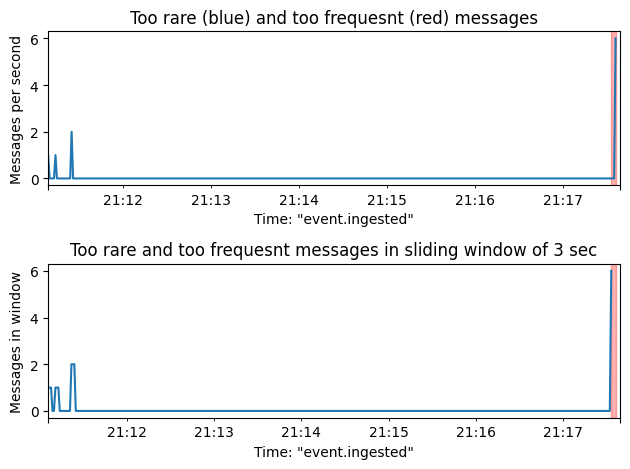

Anomaly found: too frequent messages in the following time frames:
	 from 2024-01-27 21:17:33 to 2024-01-27 21:17:36


In [6]:
report_anomalies(logs_dict, 'event.ingested', WIN_SIZE_SEC)

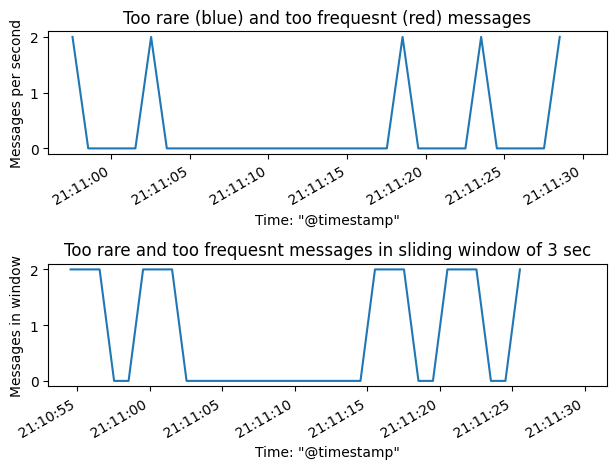

No anomalies found


In [7]:
report_anomalies(logs_dict, '@timestamp', WIN_SIZE_SEC)

### Generated logs

In [8]:
def gen_data_and_report_result(noise):
    msg_secs = np.cumsum(noise)
    msg_times = [datetime.datetime.now() + datetime.timedelta(seconds=msg_sec) for msg_sec in msg_secs]

    gen_logs_dict = []
    for msg_time in msg_times:
        gen_logs_dict.append({'data': None, 'ts': msg_time.strftime('%Y-%m-%dT%H:%M:%S.%fZ')})

    report_anomalies(gen_logs_dict, 'ts', WIN_SIZE_SEC)

In [9]:
N_PTS = 1000

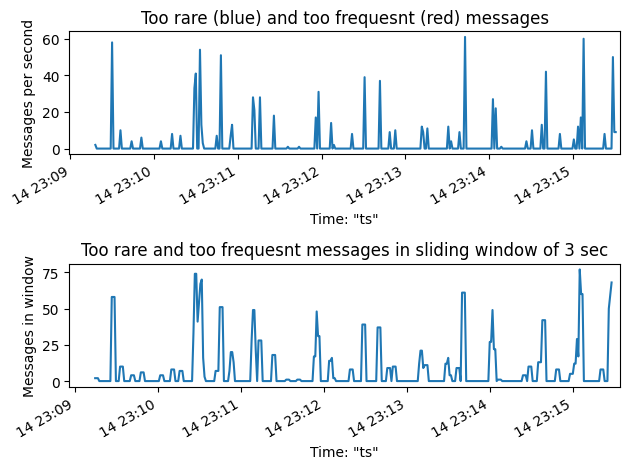

No anomalies found


In [10]:
noise = np.random.normal(loc=-8*WIN_SIZE_SEC, scale=5*WIN_SIZE_SEC, size=N_PTS)
noise[noise < 0] = 0
gen_data_and_report_result(noise)

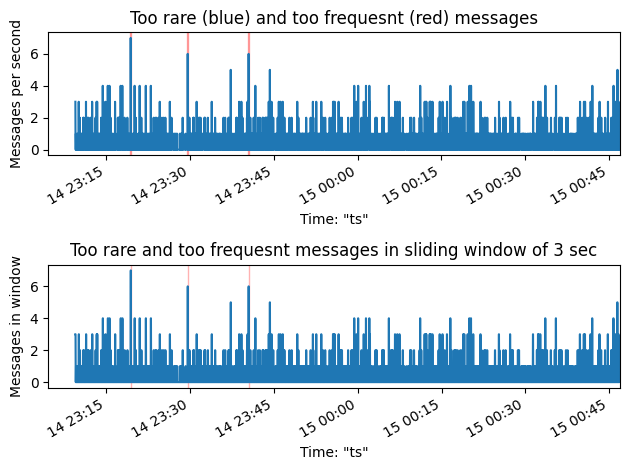

Anomaly found: too frequent messages in the following time frames:
	 from 2024-02-14 23:19:21.073117 to 2024-02-14 23:19:26.073117
	 from 2024-02-14 23:29:33.073117 to 2024-02-14 23:29:38.073117
	 from 2024-02-14 23:40:27.073117 to 2024-02-14 23:40:32.073117


In [11]:
noise = 2*WIN_SIZE_SEC*np.random.poisson(lam=1, size=N_PTS).astype(float)
noise[noise < 0] = 0
gen_data_and_report_result(noise)

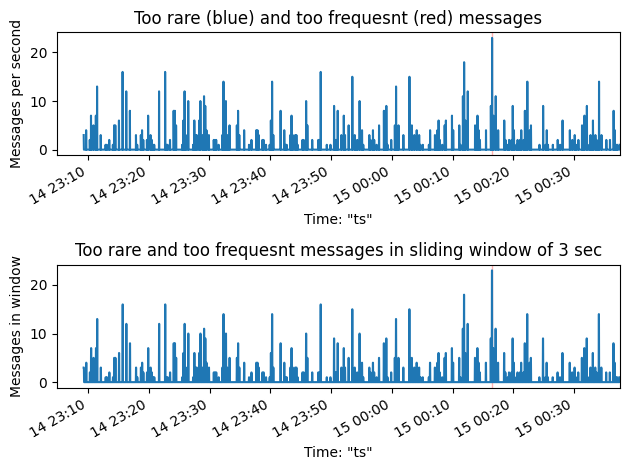

Anomaly found: too frequent messages in the following time frames:
	 from 2024-02-15 00:16:27.387155 to 2024-02-15 00:16:32.387155


In [12]:
noise = 4*WIN_SIZE_SEC*(np.random.poisson(lam=4, size=N_PTS).astype(float) - 5)
noise[noise < 2] = 0
gen_data_and_report_result(noise)

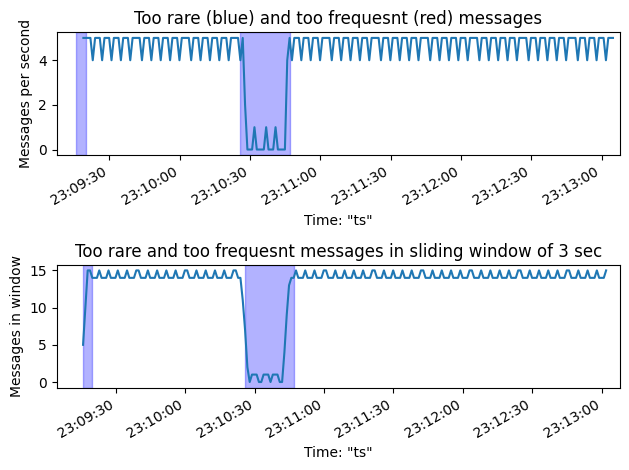

Anomaly found: too rare messages in the following time frames:
	 from 2024-02-14 23:09:15.878172 to 2024-02-14 23:09:19.878172
	 from 2024-02-14 23:10:25.878172 to 2024-02-14 23:10:46.878172


In [13]:
noise = np.array([0.07*WIN_SIZE_SEC]*N_PTS)
noise[N_PTS//3 - 2:N_PTS//3 + 2] = 1.5*WIN_SIZE_SEC
gen_data_and_report_result(noise)